In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
Npoints = 10000

In [4]:
x = torch.rand(Npoints,1).sort(dim=0)[0]
eps = torch.randn(Npoints,1)
noise_std = torch.abs(0.01*torch.cos(2*x))
noise_var = torch.square(noise_std)
noise = noise_std * eps

In [5]:
y0 = torch.sin(x)
y = y0 + noise
MSE_min   = torch.square(noise).mean()
Gauss_min = 0.5 * (torch.log(noise_var) + torch.div(torch.square(noise),noise_var)).mean()

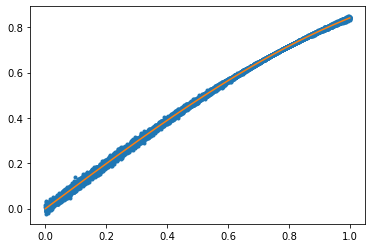

In [6]:
plt.plot(x,y,'.',x,y0,'-')

In [78]:
class Net(nn.Module):
    def __init__(self, width, depth, ANN_type='MSE'):
        super().__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        blocks = []
        blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            blocks.extend([nn.Linear(width,width), nn.ReLU()])
        
        self.ANN_type = ANN_type
        if ANN_type == 'MSE':
            blocks.append(nn.Linear(width,1))
        elif ANN_type == 'Gauss':
            blocks.append(nn.Linear(width,2))
        
        self.my_net = nn.Sequential(*blocks)
    def forward(self,x):
        x = self.my_net(x)
        if self.ANN_type == 'MSE':
            return x
        if self.ANN_type == 'Gauss':
            r = torch.zeros_like(x)
            r[:,0] = x[:,0]
            r[:,1] = nn.functional.softplus(x[:,1]) 
            return r

In [8]:
def minibatch(net, x, y, batch_size=64):
    device = net.device
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size + 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx].to(device)
        yy = y[idxx].to(device)
        yield xx,yy

In [9]:
def device_decorator(fun):
    def fun2(net,*args, **kw):
        net.cpu()
        r = fun(net,*args, **kw)
        net.to(net.device)
        return r
    return fun2    

In [10]:
@device_decorator
def custom_mse(net,x,y):
    yhat = net.forward(x)
    if net.ANN_type == 'MSE':
        return torch.square(yhat-y).mean()
    elif net.ANN_type == 'Gauss':
        return torch.square(yhat[:,0]-y).mean()

In [44]:
@device_decorator
def custom_gauss(net,x,y):
    yhat = net.forward(x)
    term1 = torch.log(yhat[:,1])
    term2 = torch.div(torch.square(y-yhat[:,0]),yhat[:,1])
    
    return 0.5 * (term1 + term2).mean()    

In [11]:
def train(net, x, y, lr=0.001, num_epochs=100, batch_size=64):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.MSELoss()
    
    net.loss_history = {'mse': [], 'custom_mse': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat, yy)
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['mse'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, MSE = {epoch_loss/epoch_weight}")

In [79]:
def train_probabilistic(net, x, y, lr=0.001, num_epochs=100, batch_size=64):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.GaussianNLLLoss()
    
    net.loss_history = {'gauss': [], 'custom_mse': [], 'custom_gauss': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat[:,0], yy, yhat[:,1])
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['gauss'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        net.loss_history['custom_gauss'].append(custom_gauss(net,x,y).item())
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, Gaussian Loss = {epoch_loss/epoch_weight}")

In [80]:
net = Net(100,1)

In [14]:
train(net, x, y, lr = 0.001, num_epochs=30)

epoch = 0, MSE = 0.001583883999689715
epoch = 10, MSE = 4.52663880714681e-05
epoch = 20, MSE = 4.089485129225068e-05


Text(0.5, 1.0, 'MSE')

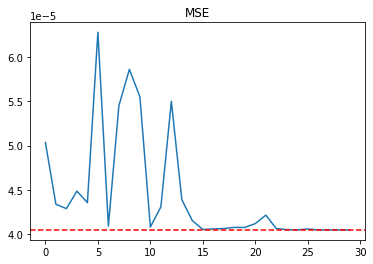

In [17]:
plt.plot(net.loss_history['custom_mse'])
plt.axhline(y=MSE_min,linestyle='--',color='r')
plt.title('MSE')

In [18]:
with torch.no_grad():
    yhat = np.array(net.forward(x))

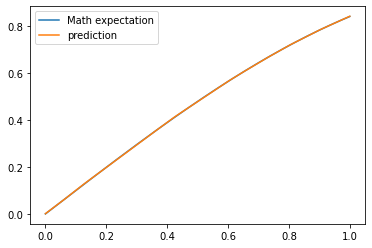

In [19]:
plt.plot(x,y0,'-',x,yhat)
plt.legend(['Math expectation', 'prediction'])

In [81]:
pnet = Net(100,1,ANN_type='Gauss')

In [82]:
train_probabilistic(pnet, x, y, lr = 0.001, num_epochs=30)

epoch = 0, Gaussian Loss = -0.7232180249512196
epoch = 10, Gaussian Loss = -0.8980213452339172
epoch = 20, Gaussian Loss = -0.9015497856140137


In [83]:
criterion = nn.GaussianNLLLoss()
print('Custom and built-in Gauss losses:', custom_gauss(pnet,x,y) - criterion(yhat[:,0], y, yhat[:,1]))

Custom and built-in Gauss losses: tensor(-4.7088e-06, grad_fn=<SubBackward0>)


Text(0.5, 1.0, 'Custom Gauss')

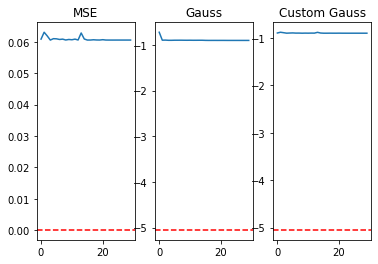

In [84]:
plt.subplot(131)
plt.plot(pnet.loss_history['custom_mse'])
plt.axhline(y=MSE_min,linestyle='--',color='r')
plt.title('MSE')
plt.subplot(132)
plt.plot(pnet.loss_history['gauss'])
plt.axhline(y=Gauss_min,linestyle='--',color='r')
plt.title('Gauss')
plt.subplot(133)
plt.plot(pnet.loss_history['custom_gauss'])
plt.axhline(y=Gauss_min,linestyle='--',color='r')
plt.title('Custom Gauss')


In [85]:
with torch.no_grad():
    yhat = pnet.forward(x)

Text(0, 0.5, 'y')

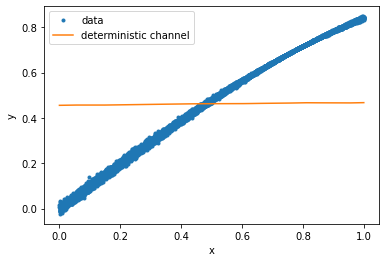

In [90]:
plt.plot(x,y,'.',x,yhat[:,0])
plt.legend(['data', 'deterministic channel'])
plt.xlabel('x')
plt.ylabel('y')

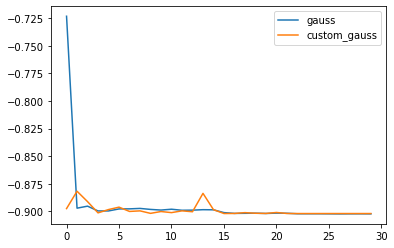

In [89]:
plt.plot(pnet.loss_history['gauss'])
plt.plot(pnet.loss_history['custom_gauss'])
plt.legend(['gauss', 'custom_gauss'])